#  MNIST test accuracy

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
import numpy as np

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: cpu


# Hyper parameter setting

In [41]:
learning_rate = 1e-1
epochs = 100
display_step = 10
batch_size = 32

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)

# Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
data tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
     

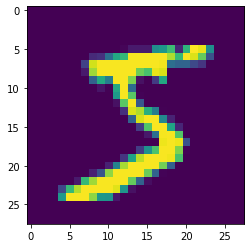

data shape: torch.Size([32, 1, 28, 28])
label: tensor([8, 6, 7, 8, 3, 9, 9, 4, 1, 7, 7, 0, 8, 6, 7, 5, 3, 0, 1, 4, 1, 9, 4, 9,
        4, 2, 5, 6, 9, 5, 4, 8])


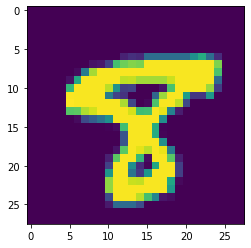

In [14]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Model & Optimization and Loss function

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 5), # number of input channel, number of output channel, kernel size   
            nn.BatchNorm2d(16),
            activation,# we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            max_pool,
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            activation,
            max_pool
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 5 * 5, 100),
            nn.BatchNorm1d(100),
            activation,
            nn.Dropout(0.2),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 64, 5, 5]
        flatten = extracted_feature.view(batch_size, -1) # [32, (64 * 5 * 5)]
        result = self.classifier(flatten)
        return result

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
model = CNN()
model.apply(init_weights)
model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

<ipython-input-40-29a6bfdbbbcb>:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


# Train & Test

In [42]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 0.16308337450027466
10 epoch loss: 0.054897285997867584
20 epoch loss: 0.0011760263005271554
30 epoch loss: 1.3090208085486665e-05
40 epoch loss: 1.5241723303915933e-05
50 epoch loss: 6.160935299703851e-05
60 epoch loss: 0.0008838378125801682
70 epoch loss: 0.0011691274121403694
80 epoch loss: 0.00027722225058823824
90 epoch loss: 1.189053728012368e-05


In [43]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("MNIST test_accuracy : {}".format(correct/total))

MNIST test_accuracy : 0.9938902258872986
